In [1]:
#loading packages
#!!!! this code was written with the March 23 version of YASS. The only thing to look at is the augment module where 
#you may have to import your new refactored functions.

%matplotlib inline
from __future__ import print_function
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import scipy.io as sio
from scipy import stats
import re
import pandas as pd
import random
import pickle
from scipy.stats import mode
from sklearn.utils import shuffle
from sklearn.cross_validation import KFold
import pandas as pd
import datetime as dt
from numpy import unravel_index
import progressbar
import math
from scipy.spatial.distance import pdist, squareform
from scipy.signal import butter, lfilter
import tensorflow as tf
import yass
from yass import read_config
from yass.augment import make_training_data, save_detect_network_params, save_triage_network_params, save_ae_network_params
from yass.augment import train_detector, train_ae, train_triage
from yass import preprocess
import matplotlib.pyplot as plt

/home/peter/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/peter/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.multichannel NN

In [9]:
#function for running multichannel NN on the simulated retinal data
def run_multinn(x_clear,x_noise,NND,path_to_detector_model,both=True):
    with tf.Session() as sess:
        #init_op = tf.global_variables_initializer()
        #sess.run(init_op)
        NND.saver.restore(sess, path_to_detector_model)
        K1, K2 = NND.filters_dict['filters']
        x_tf = tf.placeholder("float", [None, None, None])
        # save neighbor channel index

        # Temporal shape of input
        T = tf.shape(x_tf)[1]

        # input tensor into CNN
        x_cnn_tf = tf.expand_dims(x_tf, -1)


        layer1 = tf.nn.relu(conv2d(tf.expand_dims(x_tf, -1), NND.W1) + NND.b1)


        layer11 = tf.nn.relu(conv2d(layer1, NND.W11) + NND.b11)


        o_layer =tf.sigmoid( tf.squeeze(conv2d_VALID(layer11, NND.W2) + NND.b2))

        if both:
            prob_clear_multi_nn= sess.run(o_layer,feed_dict={x_tf: x_clear})
            prob_noise_multi_nn= sess.run(o_layer,feed_dict={x_tf: x_noise})
        else: 
            prob_clear_multi_nn= sess.run(o_layer,feed_dict={x_tf: x_clear})
            prob_noise_multi_nn=prob_clear_multi_nn
        return(prob_clear_multi_nn,prob_noise_multi_nn)



In [10]:
#get noise fpr-thres: we run the algorithm on noise data where we vary the threshold to obtain different 
# false positive rates. Then for a fixed fpr, we only need to look at the corresponding threshold to obtain the tpr.
from yass.neuralnetwork import NeuralNetDetector
from yass.neuralnetwork.get_nn_output import _get_o_layer
from yass.geometry import make_channel_index
from yass.neuralnetwork.utils import (weight_variable, bias_variable, conv2d,
                                      conv2d_VALID, max_pool)

path_to_detector_model='/ssd/data/shenghao/retinal/nn_models/detect_nn_newfilter.ckpt'
NND=NeuralNetDetector(path_to_detector_model)
    
names= ['clear_accuracy','n_false_pos','false_pos_rate']

data=sio.loadmat('/ssd/data/shenghao/retinal/retinal_testing_may19.mat')
noise=data['noise']
prob_clear_multi_nn,prob_noise_multi_nn = run_multinn(noise,noise,NND,path_to_detector_model,False)

roc = pd.DataFrame(columns=names)

In [13]:
#yass noise-thres
for i in np.linspace(0,1,1000):
    clear_accuracy= np.mean(prob_clear_multi_nn.max(axis=1)>=i)
    false_pos_rate= np.mean(prob_noise_multi_nn.max(axis=1)>=i)
    n_false_pos=np.sum(prob_noise_multi_nn.max(axis=1)>=i)
    result= np.array([clear_accuracy,n_false_pos,false_pos_rate])
    result = np.reshape(result,[1,len(result)])
    df = pd.DataFrame(result,index= [i], columns=names)
    roc = roc.append(df) 
roc.to_csv('/ssd/data/shenghao/retinal/yass_noise.csv', index=True, header=True)
roc= pd.read_csv('/ssd/data/shenghao/retinal/yass_noise.csv',index_col=False)
roc=roc.rename(columns={'Unnamed: 0': 'threshold'})


#show the fpr-threshold plot
from scipy import interpolate
x=roc['false_pos_rate']
y=roc['threshold']
f = interpolate.interp1d(x, y,kind='linear')
xnew = np.arange(0.01, 1, 0.00001)
ynew = f(xnew)  
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.ylim([0,1])
plt.plot(0.01,f(0.01),'x',linewidth=1,color='r')
plt.plot(0.05,f(0.05),'x',linewidth=1,color='r')
plt.plot(0.1,f(0.1),'x',linewidth=1,color='r')
plt.show()

In [34]:
#generate roc table for multi-nn
from yass.neuralnetwork import NeuralNetDetector
from yass.neuralnetwork.get_nn_output import _get_o_layer
from yass.geometry import make_channel_index
from yass.neuralnetwork.utils import (weight_variable, bias_variable, conv2d,
                                      conv2d_VALID, max_pool)
path_to_detector_model='/ssd/data/shenghao/retinal/nn_models/detect_nn_min3max15_noise2.ckpt'
NND=NeuralNetDetector(path_to_detector_model)
names= ['clear_accuracy','n_false_pos','false_pos_rate']
thres=np.array([f(0.01),f(0.05),f(0.1)])
print (thres)
data=sio.loadmat('/ssd/data/shenghao/retinal/retinal_testing_may19.mat')
x_clear=data['x_clean']
ids=data['ids'][0]

for cluster_id in np.unique(ids): 
    cluster=x_clear[ids==cluster_id]
    prob_clear_multi_nn,prob_noise_multi_nn = run_multinn(cluster,cluster,NND,path_to_detector_model,both=False)
    roc = pd.DataFrame(columns=names)
    for i in thres:
        clear_accuracy= np.mean(prob_clear_multi_nn.max(axis=1)>=i)
        false_pos_rate= np.mean(prob_noise_multi_nn.max(axis=1)>=i)
        n_false_pos=np.sum(prob_noise_multi_nn.max(axis=1)>=i)
        result= np.array([clear_accuracy,n_false_pos,false_pos_rate])
        result = np.reshape(result,[1,len(result)])
        df = pd.DataFrame(result,index= [i], columns=names)
        roc = roc.append(df) 
    roc.to_csv('/ssd/data/shenghao/retinal/results_may19/multinn%s.csv'%(int(cluster_id)), index=True, header=True)
    print (cluster_id)

[ 0.98365032  0.82782783  0.57457457]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


2.threshold detection

In [2]:
#get noise fpr-thres for threshold detection
from yass.neuralnetwork import NeuralNetDetector
from yass.neuralnetwork.get_nn_output import _get_o_layer
from yass.geometry import make_channel_index
from yass.neuralnetwork.utils import (weight_variable, bias_variable, conv2d,
                                      conv2d_VALID, max_pool)

names= ['clear_accuracy','n_false_pos','false_pos_rate']

data=sio.loadmat('/ssd/data/shenghao/retinal/retinal_testing_may19.mat')
noise=data['noise']
upper=np.max(np.abs(noise))
roc = pd.DataFrame(columns=names)

for i in np.linspace(0,1,3000):
    th=upper*i
    fp=np.zeros(noise.shape[0])
    clear_accuracy=0
    false_pos_rate=np.mean(np.abs(noise).max(axis=(1,2))>=th)
    n_false_pos=0
    result= np.array([clear_accuracy,n_false_pos,false_pos_rate])
    result = np.reshape(result,[1,len(result)])
    df = pd.DataFrame(result,index= [i], columns=names)
    roc = roc.append(df) 
    print (i)
roc.to_csv('/ssd/data/shenghao/retinal/thres_noise.csv', index=True, header=True)

0.0
0.000333444481494
0.000666888962988
0.00100033344448
0.00133377792598
0.00166722240747
0.00200066688896
0.00233411137046
0.00266755585195
0.00300100033344
0.00333444481494
0.00366788929643
0.00400133377793
0.00433477825942
0.00466822274091
0.00500166722241
0.0053351117039
0.0056685561854
0.00600200066689
0.00633544514838
0.00666888962988
0.00700233411137
0.00733577859286
0.00766922307436
0.00800266755585
0.00833611203735
0.00866955651884
0.00900300100033
0.00933644548183
0.00966988996332
0.0100033344448
0.0103367789263
0.0106702234078
0.0110036678893
0.0113371123708
0.0116705568523
0.0120040013338
0.0123374458153
0.0126708902968
0.0130043347783
0.0133377792598
0.0136712237412
0.0140046682227
0.0143381127042
0.0146715571857
0.0150050016672
0.0153384461487
0.0156718906302
0.0160053351117
0.0163387795932
0.0166722240747
0.0170056685562
0.0173391130377
0.0176725575192
0.0180060020007
0.0183394464822
0.0186728909637
0.0190063354451
0.0193397799266
0.0196732244081
0.0200066688896
0.02034

0.17639213071
0.176725575192
0.177059019673
0.177392464155
0.177725908636
0.178059353118
0.178392797599
0.178726242081
0.179059686562
0.179393131044
0.179726575525
0.180060020007
0.180393464488
0.18072690897
0.181060353451
0.181393797933
0.181727242414
0.182060686896
0.182394131377
0.182727575859
0.18306102034
0.183394464822
0.183727909303
0.184061353785
0.184394798266
0.184728242748
0.185061687229
0.185395131711
0.185728576192
0.186062020674
0.186395465155
0.186728909637
0.187062354118
0.1873957986
0.187729243081
0.188062687563
0.188396132044
0.188729576526
0.189063021007
0.189396465488
0.18972990997
0.190063354451
0.190396798933
0.190730243414
0.191063687896
0.191397132377
0.191730576859
0.19206402134
0.192397465822
0.192730910303
0.193064354785
0.193397799266
0.193731243748
0.194064688229
0.194398132711
0.194731577192
0.195065021674
0.195398466155
0.195731910637
0.196065355118
0.1963987996
0.196732244081
0.197065688563
0.197399133044
0.197732577526
0.198066022007
0.198399466489
0.19

0.361120373458
0.361453817939
0.361787262421
0.362120706902
0.362454151384
0.362787595865
0.363121040347
0.363454484828
0.36378792931
0.364121373791
0.364454818273
0.364788262754
0.365121707236
0.365455151717
0.365788596199
0.36612204068
0.366455485162
0.366788929643
0.367122374125
0.367455818606
0.367789263088
0.368122707569
0.368456152051
0.368789596532
0.369123041014
0.369456485495
0.369789929977
0.370123374458
0.37045681894
0.370790263421
0.371123707903
0.371457152384
0.371790596866
0.372124041347
0.372457485829
0.37279093031
0.373124374792
0.373457819273
0.373791263755
0.374124708236
0.374458152718
0.374791597199
0.375125041681
0.375458486162
0.375791930644
0.376125375125
0.376458819607
0.376792264088
0.37712570857
0.377459153051
0.377792597533
0.378126042014
0.378459486495
0.378792930977
0.379126375458
0.37945981994
0.379793264421
0.380126708903
0.380460153384
0.380793597866
0.381127042347
0.381460486829
0.38179393131
0.382127375792
0.382460820273
0.382794264755
0.383127709236
0.

0.546515505168
0.54684894965
0.547182394131
0.547515838613
0.547849283094
0.548182727576
0.548516172057
0.548849616539
0.54918306102
0.549516505502
0.549849949983
0.550183394465
0.550516838946
0.550850283428
0.551183727909
0.551517172391
0.551850616872
0.552184061354
0.552517505835
0.552850950317
0.553184394798
0.55351783928
0.553851283761
0.554184728243
0.554518172724
0.554851617206
0.555185061687
0.555518506169
0.55585195065
0.556185395132
0.556518839613
0.556852284095
0.557185728576
0.557519173058
0.557852617539
0.558186062021
0.558519506502
0.558852950984
0.559186395465
0.559519839947
0.559853284428
0.56018672891
0.560520173391
0.560853617873
0.561187062354
0.561520506836
0.561853951317
0.562187395799
0.56252084028
0.562854284762
0.563187729243
0.563521173725
0.563854618206
0.564188062688
0.564521507169
0.564854951651
0.565188396132
0.565521840614
0.565855285095
0.566188729577
0.566522174058
0.56685561854
0.567189063021
0.567522507503
0.567855951984
0.568189396465
0.568522840947
0.

0.730576858953
0.730910303434
0.731243747916
0.731577192397
0.731910636879
0.73224408136
0.732577525842
0.732910970323
0.733244414805
0.733577859286
0.733911303768
0.734244748249
0.734578192731
0.734911637212
0.735245081694
0.735578526175
0.735911970657
0.736245415138
0.73657885962
0.736912304101
0.737245748583
0.737579193064
0.737912637546
0.738246082027
0.738579526509
0.73891297099
0.739246415472
0.739579859953
0.739913304435
0.740246748916
0.740580193398
0.740913637879
0.741247082361
0.741580526842
0.741913971324
0.742247415805
0.742580860287
0.742914304768
0.74324774925
0.743581193731
0.743914638213
0.744248082694
0.744581527176
0.744914971657
0.745248416139
0.74558186062
0.745915305102
0.746248749583
0.746582194065
0.746915638546
0.747249083028
0.747582527509
0.747915971991
0.748249416472
0.748582860954
0.748916305435
0.749249749917
0.749583194398
0.74991663888
0.750250083361
0.750583527843
0.750916972324
0.751250416806
0.751583861287
0.751917305769
0.75225075025
0.752584194732
0.

0.914638212738
0.914971657219
0.915305101701
0.915638546182
0.915971990664
0.916305435145
0.916638879627
0.916972324108
0.91730576859
0.917639213071
0.917972657553
0.918306102034
0.918639546516
0.918972990997
0.919306435478
0.91963987996
0.919973324441
0.920306768923
0.920640213404
0.920973657886
0.921307102367
0.921640546849
0.92197399133
0.922307435812
0.922640880293
0.922974324775
0.923307769256
0.923641213738
0.923974658219
0.924308102701
0.924641547182
0.924974991664
0.925308436145
0.925641880627
0.925975325108
0.92630876959
0.926642214071
0.926975658553
0.927309103034
0.927642547516
0.927975991997
0.928309436479
0.92864288096
0.928976325442
0.929309769923
0.929643214405
0.929976658886
0.930310103368
0.930643547849
0.930976992331
0.931310436812
0.931643881294
0.931977325775
0.932310770257
0.932644214738
0.93297765922
0.933311103701
0.933644548183
0.933977992664
0.934311437146
0.934644881627
0.934978326109
0.93531177059
0.935645215072
0.935978659553
0.936312104035
0.936645548516
0.

In [5]:
#plot fpr-thres 
roc= pd.read_csv('/ssd/data/shenghao/retinal/thres_noise.csv',index_col=False)
roc=roc.rename(columns={'Unnamed: 0': 'threshold'})

from scipy import interpolate

x=roc['false_pos_rate']

y=roc['threshold']

f = interpolate.interp1d(x, y,kind='linear')

xnew = np.arange(0.005, 1, 0.00001)
ynew = f(xnew) 


plt.plot(x, y, 'o', xnew, ynew, '-')

plt.plot(0.01,f(0.01),'x',linewidth=1,color='r')
plt.plot(0.05,f(0.05),'x',linewidth=1,color='r')
plt.plot(0.1,f(0.1),'x',linewidth=1,color='r')


plt.show()

In [8]:
#evaluating threshold detection method
data=sio.loadmat('/ssd/data/shenghao/retinal/retinal_testing_may19.mat')
x_clear=data['x_clean']
ids=data['ids'][0]
noise=data['noise']
upper=np.max(np.abs(noise))
thres=np.array([f(0.01),f(0.05),f(0.1)])*upper
print(thres)
names= ['clear_accuracy','n_false_pos','false_pos_rate']

for cluster_id in np.unique(ids): 
    cluster=x_clear[ids==cluster_id]
    noise=cluster
    #upper=np.max(np.abs(cluster))
    roc = pd.DataFrame(columns=names)
    
    #cluster=cluster[:,47-r:47+r+1,:]

    for i in thres:
        th=i

        clear_accuracy=np.mean(np.abs(cluster).max(axis=(1,2))>=th)
        false_pos_rate=np.mean(np.abs(noise).max(axis=(1,2))>=th)
        n_false_pos=np.sum(np.abs(noise).max(axis=(1,2))>=th)



        result= np.array([clear_accuracy,n_false_pos,false_pos_rate])
        result = np.reshape(result,[1,len(result)])
        df = pd.DataFrame(result,index= [i], columns=names)
        roc = roc.append(df) 
    roc.to_csv('/ssd/data/shenghao/retinal/results_may19//thres%s.csv'%(int(cluster_id)), index=True, header=True)
    print (cluster_id)

[ 4.77788885  4.38100678  4.20960269]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


3.making final plots

In [14]:
NN_names=list(['multinn','thres'])

data=sio.loadmat('/ssd/data/shenghao/retinal/retinal_testing_may19.mat')
ids=data['ids'][0]
ids=np.unique(ids)
ptp=data['ptp'][0]
      

path_to_results='/ssd/data/shenghao/retinal/results_may19/'



for NN in NN_names:  
   

    for i in ids:
        exec (("roc_%s_%s=pd.read_csv(os.path.join(path_to_results, '%s%s.csv'),index_col=False)")%(NN,i,NN,i))
        exec (("roc_%s_%s=roc_%s_%s.rename(columns={'Unnamed: 0': 'threshold'})")%(NN,i,NN,i))
        exec (("roc_%s_%s=roc_%s_%s.sort_values(by='threshold',ascending=False)")%(NN,i,NN,i))


columns=['ptp','clear_accuracy','id']

fp_id=np.array([1,2,3])

cnt=0

for i in fp_id:
    for NN in NN_names:  
        exec (("snr_%s_%s=pd.DataFrame(columns=columns)")%(NN,i))

        for j in ids:
            exec   (("result=np.array([ptp[j],roc_%s_%s['clear_accuracy'][cnt],j])") % (NN,j) )
            result = np.reshape(result,[1,3])
            df = pd.DataFrame(result, columns=columns)
            exec (("snr_%s_%s=snr_%s_%s.append(df)")%(NN,i,NN,i))
    cnt=cnt+1


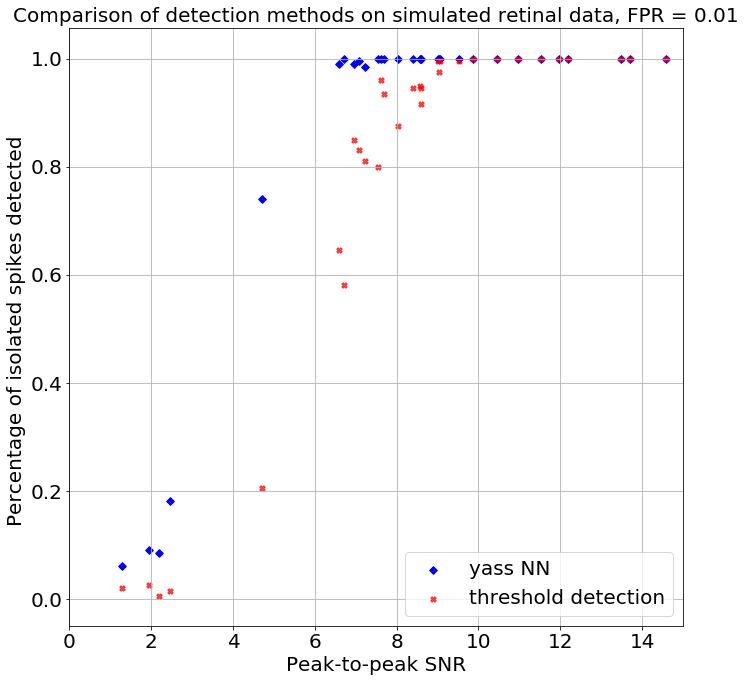

In [32]:


ax1=snr_multinn_1.plot.scatter(x='ptp',y='clear_accuracy',color='b',marker='D',s=30,label='yass NN',figsize=(11,11), title='Comparison of detection methods on simulated retinal data, FPR = 0.01')
ax2=snr_thres_1.plot.scatter(ax=ax1, x='ptp',y='clear_accuracy',color='r',marker='X',s=30,label='threshold detection',figsize=(11,11), alpha=0.7)

#ax3=snr_NN_max_10.plot(ax=ax1,y='clear_accuracy',marker='x',markersize=12,label='Trained with Max 10 Data',linewidth=6,figsize=(9,9))
#ax4=snr_NN.plot(ax=ax1,y='clear_accuracy',marker='D',markersize=12,label='Trained with no Max',linewidth=4,figsize=(9,9))

ax1.legend(loc='lower right',fontsize=20)
#ax1.legend_.remove()

plt.ylabel("Percentage of isolated spikes detected ",fontsize=20)
plt.xlabel("Peak-to-peak SNR",fontsize=20)

#plt.xlim([-0.05,3.05])

#plt.ylim([0,1.01])
#y_ticks = np.arange(0,1.1,0.1)  
#ax1.set_yticks(y_ticks)  

plt.xlim([0,15])
x_ticks = np.arange(0,15,2)  
ax1.set_xticks(x_ticks)  
ax1.grid(True)


ax1.title.set_size(20)
plt.tick_params(axis='both', which='major', labelsize=20)

fig = ax1.get_figure()
plt.show()
fig.savefig("retinal_001.pdf")
